We begin by downloading the required dataset, which is provided in the GitHub repository under the filename electricity-normalized.csv, and by importing the necessary packages for the analysis.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)

In [8]:
# ELEC2 data set
# downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv('electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

# randomly permuted data 
perm = np.random.choice(N,N,replace=False)
X_perm = X[perm]
Y_perm = Y[perm]

# weights and tags (parameters for new methods)
rho = 0.90; rho_LS = 0.99

The following function defines the implementation of three methods: CP+LS, NexCP+LS, and NexCP+WLS. Specifically, when weights is set to NULL, the function corresponds to CP+LS. When weights is provided but tags is NULL, it implements NexCP+LS. Finally, when both weights and tags are specified, the function corresponds to NexCP+WLS.

In [9]:
# conformal prediction with least squares
def CP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(tags)==0):
        tags = np.ones(n+1)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    weights = weights / np.sum(weights)
    
    # randomly permute one weight for the regression
    random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
    tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

    XtX = (X.T*tags[:-1]).dot(X) + np.outer(x,x)*tags[-1]
    a = Y - X.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b = -X.dot(np.linalg.solve(XtX,x))*tags[-1]
    a1 = -x.T.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b1 = 1 - x.T.dot(np.linalg.solve(XtX,x))*tags[-1]
    # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
    # then a + b*y = residuals of data points 1,..,n
    # and a1 + b1*y = residual of data point n+1
    
    y_knots = np.sort(np.unique(np.r_[((a-a1)/(b1-b))[b1-b!=0],((-a-a1)/(b1+b))[b1+b!=0]]))
    y_inds_keep = np.where( ((np.abs(np.outer(a1+b1*y_knots,np.ones(n))) > \
       np.abs(np.outer(np.ones(len(y_knots)),a)+np.outer(y_knots,b))) *\
                             weights[:-1] ).sum(1) <= 1-alpha )[0] 
    y_PI = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]])
    if(weights[:-1].sum() <= 1-alpha):
        y_PI = np.array([-np.inf,np.inf])
    return y_PI


The following code is used to apply the algorithm to the dataset.

In [10]:
# run all methods
PI_CP_LS = np.zeros((N,2))
PI_CP_LS[:train_lag,0]=-np.inf;PI_CP_LS[:train_lag,1]=np.inf
PI_CP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_LS = np.copy(PI_CP_LS)
PI_nexCP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_WLS = np.copy(PI_CP_LS)
PI_nexCP_WLS_perm = np.copy(PI_CP_LS)

for n in np.arange(train_lag,N):
    print(n)
    weights=rho**(np.arange(n,0,-1))
    tags=rho_LS**(np.arange(n,-1,-1))
    PI_CP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha)
    PI_CP_LS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha)
    PI_nexCP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,weights=weights)
    PI_nexCP_LS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha,weights=weights)
    PI_nexCP_WLS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,\
                            weights=weights,tags=tags)
    PI_nexCP_WLS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha,\
                            weights=weights,tags=tags)
    

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


/var/folders/x1/hydqdt_j21x02zrx1q3081hw0000gn/T/ipykernel_14093/1681253662.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])


220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469


The following code is used to store the results and generate plots.

In [11]:
# compute coverage and PI width for all settings

cov_CP_LS = (PI_CP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_CP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_CP_LS = PI_CP_LS[train_lag:,1]-PI_CP_LS[train_lag:,0]
cov_CP_LS_perm = (PI_CP_LS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_CP_LS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_CP_LS_perm = PI_CP_LS_perm[train_lag:,1]-PI_CP_LS_perm[train_lag:,0]

cov_nexCP_LS = (PI_nexCP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_LS = PI_nexCP_LS[train_lag:,1]-PI_nexCP_LS[train_lag:,0]
cov_nexCP_LS_perm = (PI_nexCP_LS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_nexCP_LS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_nexCP_LS_perm = PI_nexCP_LS_perm[train_lag:,1]-PI_nexCP_LS_perm[train_lag:,0]

cov_nexCP_WLS = (PI_nexCP_WLS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_WLS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_WLS = PI_nexCP_WLS[train_lag:,1]-PI_nexCP_WLS[train_lag:,0]
cov_nexCP_WLS_perm = (PI_nexCP_WLS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_nexCP_WLS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_nexCP_WLS_perm = PI_nexCP_WLS_perm[train_lag:,1]-PI_nexCP_WLS_perm[train_lag:,0]


# save results

np.savetxt('results3/ELEC2_cov_CP_LS.txt',cov_CP_LS)
np.savetxt('results3/ELEC2_PI_width_CP_LS.txt',PI_width_CP_LS)
np.savetxt('results3/ELEC2_perm_cov_CP_LS.txt',cov_CP_LS_perm)
np.savetxt('results3/ELEC2_perm_PI_width_CP_LS.txt',PI_width_CP_LS_perm)

np.savetxt('results3/ELEC2_cov_nexCP_LS.txt',cov_nexCP_LS)
np.savetxt('results3/ELEC2_PI_width_nexCP_LS.txt',PI_width_nexCP_LS)
np.savetxt('results3/ELEC2_perm_cov_nexCP_LS.txt',cov_nexCP_LS_perm)
np.savetxt('results3/ELEC2_perm_PI_width_nexCP_LS.txt',PI_width_nexCP_LS_perm)

np.savetxt('results3/ELEC2_cov_nexCP_WLS.txt',cov_nexCP_WLS)
np.savetxt('results3/ELEC2_PI_width_nexCP_WLS.txt',PI_width_nexCP_WLS)
np.savetxt('results3/ELEC2_perm_cov_nexCP_WLS.txt',cov_nexCP_WLS_perm)
np.savetxt('results3/ELEC2_perm_PI_width_nexCP_WLS.txt',PI_width_nexCP_WLS_perm)

In [12]:
[['ELEC2 data','',''],\
['      ','mean coverage   ','mean width'],\
['CP+LS    ',np.mean(cov_CP_LS),np.mean(PI_width_CP_LS)],\
['nexCP+LS ',np.mean(cov_nexCP_LS),np.mean(PI_width_nexCP_LS)],\
['nexCP+WLS',np.mean(cov_nexCP_WLS),np.mean(PI_width_nexCP_WLS)],\
['Permuted ELEC2 data','',''],\
['      ','mean coverage   ','mean width'],\
['CP+LS    ',np.mean(cov_CP_LS_perm),np.mean(PI_width_CP_LS_perm)],\
['nexCP+LS ',np.mean(cov_nexCP_LS_perm),np.mean(PI_width_nexCP_LS_perm)],\
['nexCP+WLS',np.mean(cov_nexCP_WLS_perm),np.mean(PI_width_nexCP_WLS_perm)]]

[['ELEC2 data', '', ''],
 ['      ', 'mean coverage   ', 'mean width'],
 ['CP+LS    ', np.float64(0.8519736842105263), np.float64(0.564589860993417)],
 ['nexCP+LS ', np.float64(0.9985047846889952), np.float64(inf)],
 ['nexCP+WLS', np.float64(0.999700956937799), np.float64(inf)],
 ['Permuted ELEC2 data', '', ''],
 ['      ', 'mean coverage   ', 'mean width'],
 ['CP+LS    ', np.float64(0.8986244019138756), np.float64(0.6387322574269696)],
 ['nexCP+LS ', np.float64(1.0), np.float64(inf)],
 ['nexCP+WLS', np.float64(1.0), np.float64(inf)]]

In [13]:
window = 300 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    

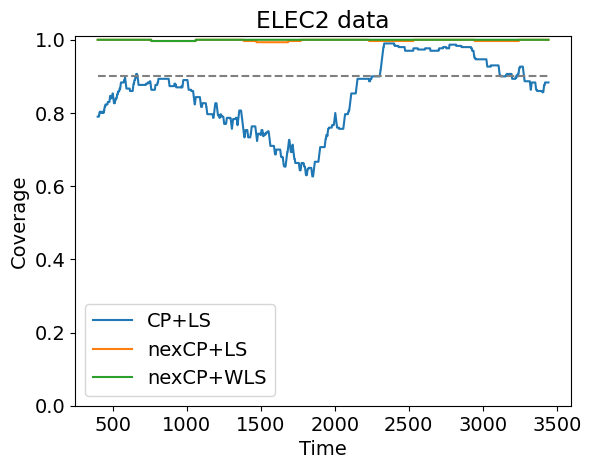

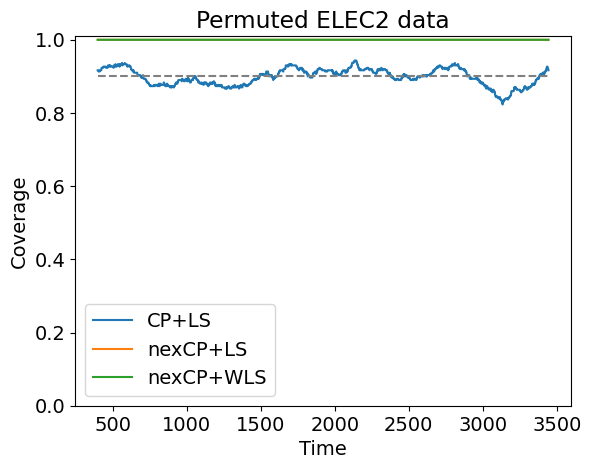

In [17]:
sm_cov_CP_LS = rolling_avg(cov_CP_LS,window)
sm_cov_nexCP_LS = rolling_avg(cov_nexCP_LS,window)
sm_cov_nexCP_WLS = rolling_avg(cov_nexCP_WLS,window)

sm_cov_CP_LS_perm = rolling_avg(cov_CP_LS_perm,window)
sm_cov_nexCP_LS_perm = rolling_avg(cov_nexCP_LS_perm,window)
sm_cov_nexCP_WLS_perm = rolling_avg(cov_nexCP_WLS_perm,window)

plt.rcParams.update({'font.size': 14})

plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS)
plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('ELEC2 data')
plt.ylim([0,1.01])
plt.savefig('results3/ELEC2_coverage.png',dpi=400,bbox_inches='tight')
plt.show()


plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS_perm)
plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Permuted ELEC2 data')
plt.ylim([0,1.01])
plt.savefig('results3/ELEC2_perm_coverage.png',dpi=400,bbox_inches='tight')
plt.show()